# Dataset [River Water Quality EDA and Forecasting](https://www.kaggle.com/vbmokin/wq-southern-bug-river-01052021)

Dataset contains data on river water quality for 8 indicators for 22 monitoring stations.

Data for 2000-2021 for the Southern Bug (or Pivdennyi Booh) river.

### Possible Tasks:

1. Analysis of data dependences, including EDA.

2. Prediction of the data in the certain station by data from upstream stations with the highest accuracy.

### Map of the stations:
http://monitoring.davr.gov.ua/EcoWaterMon/GDKMap/Index

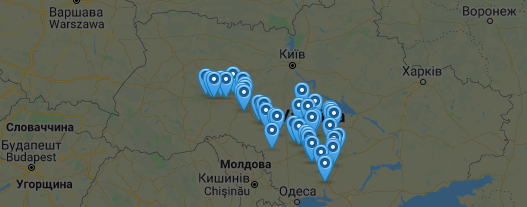

The water quality state monitoring stations of the Southern Bug (or Pivdennyi Booh) river.
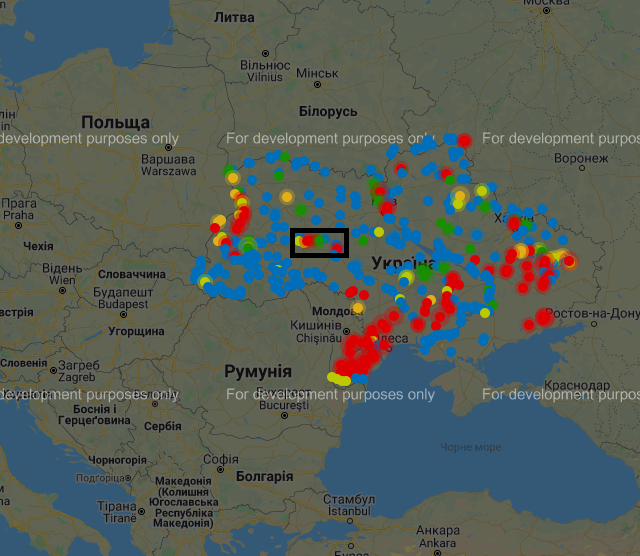

## Acknowledgements
* [Data Science for tabular data: Advanced Techniques](https://www.kaggle.com/vbmokin/data-science-for-tabular-data-advanced-techniques)
* [EDA for tabular data: Advanced Techniques](https://www.kaggle.com/vbmokin/eda-for-tabular-data-advanced-techniques)
* [Datasets for river water quality prediction](https://www.kaggle.com/vbmokin/datasets-for-river-water-quality-prediction)
* [AI-ML-DS Training. L1T : Titanic - Decision Tree](https://www.kaggle.com/vbmokin/ai-ml-ds-training-l1t-titanic-decision-tree)
* [AI-ML-DS Training. L1T : NH4 - linear regression](https://www.kaggle.com/vbmokin/ai-ml-ds-training-l1t-nh4-linear-regression)
* [Heart Disease - Automatic AdvEDA & FE & 20 models](https://www.kaggle.com/vbmokin/heart-disease-automatic-adveda-fe-20-models)
* [BOD prediction in river - 15 regression models](https://www.kaggle.com/vbmokin/bod-prediction-in-river-15-regression-models)
* [The system "MONITORING AND ENVIRONMENTAL ASSESSMENT OF WATER RESOURCES OF UKRAINE", State Agency of Water Resources of Ukraine](http://monitoring.davr.gov.ua/EcoWaterMon/GDKMap/Index)
* [WQ SB river : EDA and Forecasting](https://www.kaggle.com/vbmokin/wq-sb-river-eda-and-forecasting)

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import libraries](#1)
1. [Download data](#2)
1. [EDA & FE & Preprocessing data](#3)
    - [Statistics & FE](#3.1)
    - [Data standartization](#3.2)
    - [Training data splitting](#3.3)
    - [Cross-validation of training data](#3.4)
1. [Modeling](#4)
    - [Linear Regression](#4.1)
    - [Random Forest Regressor](#4.2)
    - [XGBoost Regressor](#4.3)    
1. [Test prediction](#5)
1. [Results visualization](#6)
1. [Select the best model](#6)

## 1. Import libraries<a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Work with Data - the main Python libraries
import numpy as np
import pandas as pd
import pandas_profiling as pp

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Metrics
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')

In [ ]:
pd.set_option('max_colwidth', 200)

## 2. Download data<a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Download data
data = pd.read_csv('../input/wq-southern-bug-river-01052021/PB_All_2000_2021.csv', sep=';', header=0)
data

In [ ]:
# Information for training data
data.info()

In [ ]:
# Download data about monitoring stations
data_about = pd.read_csv('../input/wq-southern-bug-river-01052021/PB_stations.csv', sep=';', header=0, encoding='cp1251')
data_about.sort_values(by=['length'], ascending=False)

## 3. EDA & FE & Preprocessing data<a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Amount data observations of stations
data['id'].value_counts().sort_values().plot(kind='barh')

In [ ]:
# Determination the year of observations
data['ds'] = pd.to_datetime(data['date'])
data['year'] = data['ds'].dt.year
data.info()

In [ ]:
# Determination the start year of observations for all stations
data[['id', 'year']].groupby(by=['id']).min().sort_values(by=['year'], ascending=False)

As you can see, the stations 5 & 13 have little data.

In [ ]:
# Determination the final year of observations for all stations
data[['id', 'year']].groupby(by=['id']).max().sort_values(by=['year'], ascending=False)

As you can see, only stations 3, 5, 10, 14, 15, 16 and 22 have modern data.


Although, if you limit yourself to 2018, then you can take all the stations.

Сonsider only stations 14, 15, 16.

In [ ]:
# Information about stations 14, 15, 16
stations_good = [14, 15, 16]
data_about[data_about['id'].isin(stations_good)]

In [ ]:
# Set target indicator
target_data_name = 'O2'
#feature_target_all = ['NH4', 'BSK5', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
feature_target_all = ['BSK5', 'NH4']
feature_data_all = feature_target_all + [target_data_name]
feature_data_all

In [ ]:
# Data sampling only for good stations
df_indicator = data[['id', 'ds'] + feature_data_all]
df_indicator = df_indicator[df_indicator['id'].isin(stations_good)].dropna().reset_index(drop=True)
df_indicator

In [ ]:
cols = []
for station in stations_good:
    for feature in feature_data_all:
        cols.append(str(station) + "_" + feature)
cols

In [ ]:
df = pd.pivot_table(df_indicator, index=["ds"], columns=["id"], values=feature_data_all).dropna()
df.columns = cols
df

In [ ]:
# Data visualization
df.plot(figsize=(12,10))

In [ ]:
# EDA with Pandas Profiling
pp.ProfileReport(df)

In [ ]:
df.describe([.05, .5, .95])

In [ ]:
print(len(df))
for col in df.columns.tolist():
    df = df[df[col] <= float(df.quantile([.96])[col])]
df = df.reset_index(drop=True)
print(len(df))
df.describe()

In [ ]:
# Data visualization
df.plot(figsize=(12,10))

In [ ]:
# df = df[(df['15_O2'] <= 0.4648) & (df['16_NH4'] <= 15.648) & (df['16_O2'] <= 15.78)].reset_index(drop=True)
# df.describe([.05, .5, .96])

In [ ]:
#len(df)

In [ ]:
# Set target data
target_name = '16_' + target_data_name
target_data = df.pop(target_name)
target_data

In [ ]:
# Dividing data into training and test
train, test, target, target_test = train_test_split(df, target_data, test_size=0.4, random_state=0)
print(train.shape, test.shape)

### 3.1. Statistics & FE<a class="anchor" id="3.1"></a>

[Back to Table of Contents](#0.1)

The analysis showed that many values are only available in stations 1 and 2, while others have much less data. I propose select only these two stations.

In [ ]:
# Display the statistics for training data
train.describe([.05, .5, .96])

In [ ]:
# Display the statistics for test data
test.describe()

### 3.2. Data standartization<a class="anchor" id="3.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Standartization data
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)

# Display training data
train

In [ ]:
# Standartization data
test = pd.DataFrame(scaler.transform(test), columns = test.columns)

### 3.3. Training data splitting<a class="anchor" id="3.3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Training data splitting to new training (part of the all training) and validation data
train_all = train.copy()
target_all = target.copy()
train, valid, target_train, target_valid = train_test_split(train_all, target_all, test_size=0.2, random_state=0)

In [ ]:
# Display information about new training data
train.info()

In [ ]:
# Display information about validation data
valid.info()

### 3.4. Cross-validation of training data<a class="anchor" id="3.4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Cross-validation of training data with shuffle
cv_train = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)

**ADDITIONAL TASK:** 
1. Set number of splitting = 5, 7, 10 and to compare of results.
2. Try use another method for cross-validation of training data (without shuffle):

        KFold(n_splits=5, shuffle=False, random_state=0)

## 4. Modeling<a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Creation the dataframe with the resulting score of all models
result = pd.DataFrame({'model' : ['Linear Regression', 'Random Forest Regressor', 'XGBoost Regressor'], 
                       'train_score': 0, 'valid_score': 0})
result

### 4.1. Linear Regression<a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(train, target_train)

# Prediction for training data
y_train_lr = lr.predict(train)

# Accuracy of model
r2_score_acc = round(r2_score(target_train, y_train_lr), 2)
print(f'Accuracy of Linear Regression model training is {r2_score_acc}')

# Save to result dataframe
result.loc[result['model'] == 'Linear Regression', 'train_score'] = r2_score_acc

In [ ]:
# Print rounded r2_lr = lr.predict(valid)
y_val_lr = lr.predict(valid)
r2_score_acc_valid = round(r2_score(target_valid, y_val_lr),2)
result.loc[result['model'] == 'Linear Regression', 'valid_score'] = r2_score_acc_valid
print(f'Accuracy of Linear Regression model prediction for valid dataset is {r2_score_acc_valid}')

### 4.2. Random Forest Regressor<a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
%%time
# Random Forest Regressor
rf = RandomForestRegressor()
param_grid = {'n_estimators': [50, 100], 'min_samples_leaf': [i for i in range(3,7)], 
              'max_features': ['auto'], 'max_depth': [i for i in range(3,6)], 
              'criterion': ['mse'], 'bootstrap': [False]}

# Training model
rf_CV = GridSearchCV(rf, param_grid=param_grid, cv=cv_train, verbose=False)
rf_CV.fit(train, target_train)
print(rf_CV.best_params_)

# Prediction for training data
y_train_rf = rf_CV.predict(train)

# Accuracy of model
r2_score_acc = round(r2_score(target_train, y_train_rf),2)
print(f'Accuracy of RandomForestRegressor model training is {r2_score_acc}')

# Save to result dataframe
result.loc[result['model'] == 'Random Forest Regressor', 'train_score'] = r2_score_acc

In [ ]:
# Print rounded r2_score_acc to 2 decimal values after the text
y_val_rf = rf_CV.predict(valid)
r2_score_acc_valid = round(r2_score(target_valid, y_val_rf),2)
result.loc[result['model'] == 'Random Forest Regressor', 'valid_score'] = r2_score_acc_valid
print(f'Accuracy of RandomForestRegressor model prediction for valid dataset is {r2_score_acc_valid}')

### 4.3. XGBoost Regressor<a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
%%time
# XGBoost Regressor
xgbr = xgb.XGBRegressor() 
# parameters = {'n_estimators': [60, 70, 80, 90, 95, 100, 105, 110, 120, 130, 140], 
#               'learning_rate': [0.005, 0.01, 0.05, 0.075, 0.1],
#               'max_depth': [3, 5, 7, 9],
#               'reg_lambda': [0.1, 0.3, 0.5]}

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.05, 0.01],
              'max_depth': [4, 5],
              'reg_lambda': [0.3]}

# Training model
xgb_CV = GridSearchCV(estimator=xgbr, param_grid=parameters, cv=cv_train, n_jobs=-1)
xgb_CV.fit(train, target_train)
print("Best score: %0.3f" % xgb_CV.best_score_)
print("Best parameters set:", xgb_CV.best_params_)

# Prediction for training data
y_train_xgb = xgb_CV.predict(train)

# Accuracy of model
r2_score_acc = round(r2_score(target_train, y_train_xgb),2)
print(f'Accuracy of XGBoost Regressor model training is {r2_score_acc}')

# Save to result dataframe
result.loc[result['model'] == 'XGBoost Regressor', 'train_score'] = r2_score_acc

In [ ]:
# Print rounded r2_score_acc to 2 decimal values after the text
y_val_xgb = xgb_CV.predict(valid)
r2_score_acc_valid = round(r2_score(target_valid, y_val_xgb),2)
result.loc[result['model'] == 'XGBoost Regressor', 'valid_score'] = r2_score_acc_valid
print(f'Accuracy of XGBoost Regressor model prediction for valid dataset is {r2_score_acc_valid}')

In [ ]:
# Feature importance diagram
xgbr = xgb.XGBRegressor(**xgb_CV.best_params_)
xgbr.fit(train, target_train)
fig =  plt.figure(figsize = (10,8))
axes = fig.add_subplot(111)
xgb.plot_importance(xgbr,ax = axes,height = 0.5)
plt.show();
plt.close()

**ADDITIONAL TASKS:** 
1. Try to change the parameters (see examples above).
2. Try deleting anomalous data. 
3. Add to dataframe result also calculated array: y_train, y_val.
4. Creation the function with all commands and output information (in each section of this chapter 4) for all models:

        result = get_model(train, valid, target_train, target_valid, model_name, param_grid, cv_train, result)

## 5. Test prediction<a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Prediction of target for test data for all models
y_test_lr = lr.predict(test)
y_test_rf = rf_CV.predict(test)
y_test_xgb = xgb_CV.predict(test)

## 6. Visualization<a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Building plot for prediction for the training data 
x = np.arange(len(train))
plt.figure(figsize=(16,10))
plt.scatter(x, target_train, label = "Target training data", color = 'g')
plt.scatter(x, y_train_lr, label = "Linear Regression prediction", color = 'b')
plt.scatter(x, y_train_rf, label = "Random Forest prediction", color = 'y')
plt.scatter(x, y_train_xgb, label = "XGBoost Regressor prediction", color = 'brown')
plt.plot(x, np.full(len(train), 0.5), label = "Maximum allowable value", color = 'r')
plt.title('Prediction for the training data')
plt.legend(loc='best')
plt.grid(True)

In [ ]:
# Building plot for prediction for the valid data 
x = np.arange(len(valid))
plt.figure(figsize=(16,10))
plt.scatter(x, target_valid, label = "Target valid data", color = 'g')
plt.scatter(x, y_val_lr, label = "Linear Regression prediction", color = 'b')
plt.scatter(x, y_val_rf, label = "Random Forest prediction", color = 'y')
plt.scatter(x, y_val_xgb, label = "XGBoost Regressor prediction", color = 'brown')
plt.plot(x, np.full(len(valid), 0.5), label = "Maximum allowable value", color = 'r')
plt.title('Prediction for the valid data')
plt.legend(loc='best')
plt.grid(True)

In [ ]:
# Building plot for prediction for the test data 
x = np.arange(len(test))
plt.figure(figsize=(16,10))
plt.scatter(x, target_test, label = "Target test data", color = 'g')
plt.scatter(x, y_test_lr, label = "Linear Regression prediction", color = 'b')
plt.scatter(x, y_test_rf, label = "Random Forest prediction", color = 'y')
plt.scatter(x, y_test_xgb, label = "XGBoost Regressor prediction", color = 'brown')
plt.plot(x, np.full(len(test), 0.5), label = "Maximum allowable value", color = 'r')
plt.title('Prediction for the test data')
plt.legend(loc='best')
plt.grid(True)

## 7. Select the best model <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# Display results of modeling
result.sort_values(by=['valid_score', 'train_score'], ascending=False)

In [ ]:
# Select models with good training results
result_best = result[(result['train_score'] > result['valid_score'])]

In [ ]:
# Select models with minimal overfitting
result_best = result_best[(result_best['train_score'] - result_best['valid_score']).abs() < 0.15]
result_best.sort_values(by=['valid_score', 'train_score'], ascending=False)

In [ ]:
# Select the best model
result_best.nlargest(1, 'valid_score')

In [ ]:
# Find a name of the best model (with maximal valid score)
best_model_name = result_best.loc[result_best['valid_score'].idxmax(result_best['valid_score'].max()), 'model']

In [ ]:
print(f'The best model is "{best_model_name}"')

I hope you find this notebook useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)